In [92]:
import os
from dotenv import load_dotenv
import boto3
import pandas as pd
import s3fs

load_dotenv()

aws_key = os.getenv('AWS_ACCESS_KEY_ID')
aws_secret = os.getenv('AWS_SECRET_ACCESS_KEY')

s3 = boto3.client(
    's3',
    aws_access_key_id=aws_key,
    aws_secret_access_key=aws_secret
)

### Securely using AWS keys
Using enviroment variables locally in a .env file. this is also in my gitignore file so that it is never on the repository, and only local to the people who are allowed the keys.

In [93]:


# Initialize s3fs filesystem
fs = s3fs.S3FileSystem()

# List all files in the bucket
bucket = 'kuunda-datascience-challenge'
files = fs.ls(bucket)
print('\n'.join(files))

# Concatenate all CSV files in the bucket into a single DataFrame
print(files)
csv_files = [f for f in files]
if csv_files:
    dfs = []
    for file_path in csv_files:
        with fs.open(file_path, 'rb') as f:
            dfs.append(pd.read_csv(f))
    df = pd.concat(dfs, ignore_index=True)
else:
    print("No CSV files found in the bucket.")
    df = None
df.to_csv('local_kunda.csv', index=False)


kuunda-datascience-challenge/data_0000_part_00
kuunda-datascience-challenge/data_0001_part_00
kuunda-datascience-challenge/data_0002_part_00
kuunda-datascience-challenge/data_0003_part_00
['kuunda-datascience-challenge/data_0000_part_00', 'kuunda-datascience-challenge/data_0001_part_00', 'kuunda-datascience-challenge/data_0002_part_00', 'kuunda-datascience-challenge/data_0003_part_00']


## Start of Exploritory Data Analysis
Display the pandas dataframe to get an idea of the type of information that is in each column.

In [1]:
import pandas as pd
import os
df = pd.read_csv('local_kunda.csv')
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 94085 entries, 0 to 94084
Data columns (total 70 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   customerid     94085 non-null  object 
 1   loanid         94085 non-null  object 
 2   date_add       94085 non-null  object 
 3   prodcode       94085 non-null  object 
 4   feature_1      94085 non-null  float64
 5   feature_2      94085 non-null  float64
 6   feature_3      94085 non-null  float64
 7   feature_4      94085 non-null  float64
 8   feature_5      94085 non-null  float64
 9   feature_6      94085 non-null  float64
 10  feature_7      94085 non-null  float64
 11  feature_8      94085 non-null  float64
 12  feature_9      94085 non-null  float64
 13  feature_10     94085 non-null  float64
 14  feature_11     94085 non-null  float64
 15  feature_12     94085 non-null  float64
 16  feature_13     94085 non-null  float64
 17  feature_14     94085 non-null  float64
 18  featur

Cleaning data by checking for any null values or duplicate entries from the dataset.

In [2]:
df.duplicated().sum()
df.isnull().sum().sort_values(ascending=False)



customerid       0
feature_41       0
feature_47       0
feature_46       0
feature_45       0
                ..
feature_26       0
feature_27       0
feature_28       0
feature_29       0
write_off_ind    0
Length: 70, dtype: int64

- Right now the target variable looks like it would be to classify and predict the `default_ind`
- So we drop all non-numeric values and just do a validation that all of the values are of the right type after dropping columns

In [3]:
df = df.drop(['customerid', 'loanid', 'date_add', 'prodcode','write_off_ind'], axis=1)
list(set(df.dtypes.tolist()))

[dtype('float64'), dtype('int64')]

array([[<Axes: title={'center': 'feature_1'}>,
        <Axes: title={'center': 'feature_2'}>,
        <Axes: title={'center': 'feature_3'}>,
        <Axes: title={'center': 'feature_4'}>],
       [<Axes: title={'center': 'feature_5'}>,
        <Axes: title={'center': 'feature_6'}>,
        <Axes: title={'center': 'feature_7'}>,
        <Axes: title={'center': 'feature_8'}>],
       [<Axes: title={'center': 'feature_9'}>,
        <Axes: title={'center': 'feature_10'}>,
        <Axes: title={'center': 'feature_11'}>,
        <Axes: title={'center': 'feature_12'}>],
       [<Axes: title={'center': 'feature_13'}>,
        <Axes: title={'center': 'feature_14'}>,
        <Axes: title={'center': 'feature_15'}>,
        <Axes: title={'center': 'feature_16'}>],
       [<Axes: title={'center': 'feature_17'}>,
        <Axes: title={'center': 'feature_18'}>,
        <Axes: title={'center': 'feature_19'}>,
        <Axes: title={'center': 'feature_20'}>],
       [<Axes: title={'center': 'feature_21'

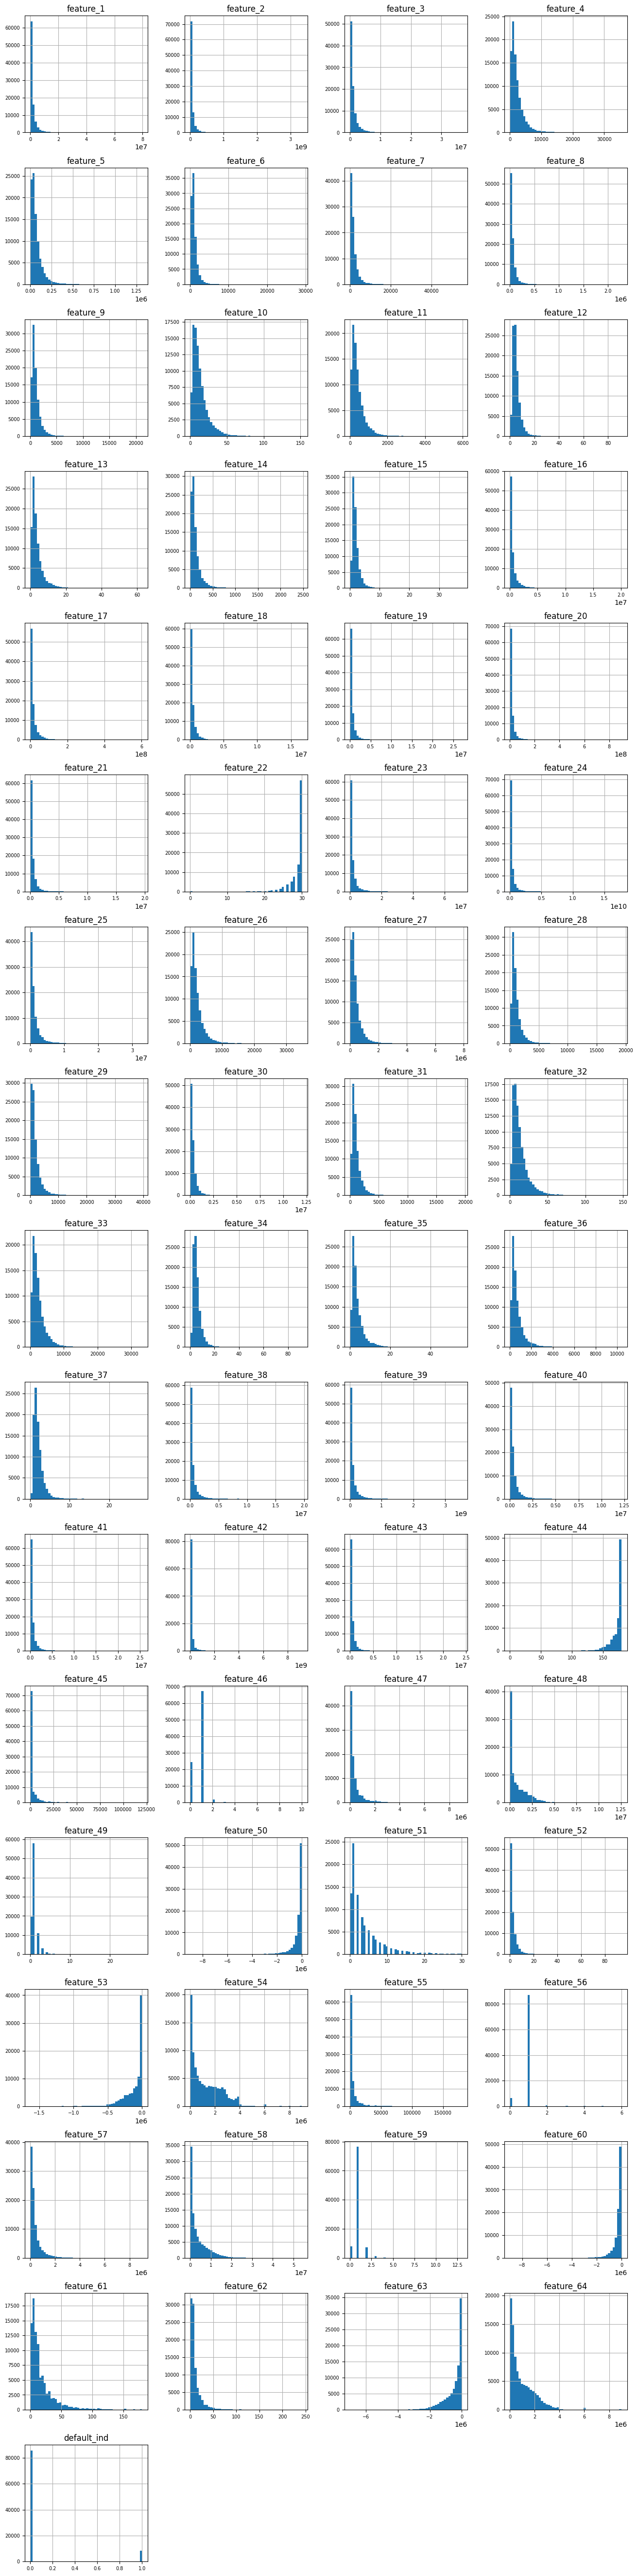

In [4]:
import math

n_columns = df.shape[1]
n_per_row = 4
n_rows = math.ceil(n_columns / n_per_row)
df.hist(
    figsize=(16, 4 * n_rows),
    bins=50,
    xlabelsize=7,
    ylabelsize=7,
    layout=(n_rows, n_per_row)
)

### Some insights from histograms
- Most of the data is quite skewed to one side
- Will have to later generate a correlation matrix to take a look at any correlations
- Most important takeaway is that our variable of interest `default_ind` clearly indicates a great class imbalance: 

<Axes: xlabel='default_ind'>

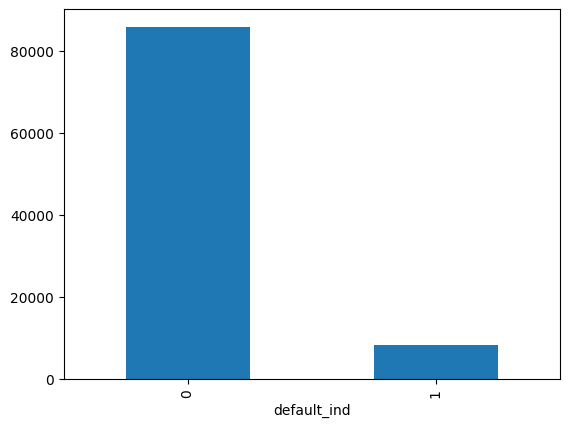

In [5]:
df['default_ind'].value_counts().plot(kind='bar')


- This imbalance will become one of the main factors in choosing which binary tree classifier we will use
- Might also require some hyper-paramer tuning in the future, as it can become cumbersome to balance our target evals


### We continue our EDA with a correlation matrix

In [6]:
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
correlation_matrix = df.corr()
correlation_matrix

,feature_1,feature_2,feature_3,feature_4,feature_5,feature_6,feature_7,feature_8,feature_9,feature_10,...,feature_56,feature_57,feature_58,feature_59,feature_60,feature_61,feature_62,feature_63,feature_64,default_ind
feature_1,1.000000,0.971763,0.918070,0.673920,0.646538,0.669089,0.760625,0.731739,0.719478,0.404217,...,-0.024862,0.299881,0.181636,-0.003384,-0.327567,-0.064337,-0.040586,-0.181636,0.233564,-0.056889
feature_2,0.971763,1.000000,0.887705,0.664842,0.682206,0.652161,0.751237,0.770695,0.707884,0.406922,...,-0.026899,0.285429,0.193947,-0.002013,-0.314323,-0.061986,-0.025585,-0.193947,0.220642,-0.056136
feature_3,0.918070,0.887705,1.000000,0.578490,0.549727,0.670572,0.670844,0.640462,0.725783,0.304211,...,-0.032155,0.297491,0.167731,-0.015458,-0.320997,-0.083701,-0.059891,-0.167731,0.214753,-0.054669
feature_4,0.673920,0.664842,0.578490,1.000000,0.964938,0.863824,0.712034,0.689126,0.619989,0.867526,...,-0.000421,0.333893,0.254689,0.027477,-0.351892,-0.034377,-0.000297,-0.254689,0.313331,-0.053795
feature_5,0.646538,0.682206,0.549727,0.964938,1.000000,0.824279,0.689829,0.723178,0.596705,0.845821,...,-0.005378,0.308866,0.267160,0.026555,-0.328639,-0.031672,0.023246,-0.267160,0.286300,-0.050662
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
feature_61,-0.064337,-0.061986,-0.083701,-0.034377,-0.031672,-0.059802,-0.053375,-0.049310,-0.081442,-0.005415,...,0.215838,-0.038351,0.440242,0.254930,0.126951,1.000000,0.741631,-0.440242,0.353211,0.102318
feature_62,-0.040586,-0.025585,-0.059891,-0.000297,0.023246,-0.023425,-0.036261,-0.014745,-0.057631,0.018622,...,0.302143,-0.044877,0.537072,0.429720,0.027561,0.741631,1.000000,-0.537072,0.382820,0.132921
feature_63,-0.181636,-0.193947,-0.167731,-0.254689,-0.267160,-0.248917,-0.194704,-0.207017,-0.180763,-0.172018,...,-0.239004,-0.599354,-1.000000,-0.255091,0.578960,-0.440242,-0.537072,1.000000,-0.817833,-0.119593
feature_64,0.233564,0.220642,0.214753,0.313331,0.286300,0.299534,0.278188,0.254791,0.247464,0.224861,...,0.214244,0.630591,0.817833,0.229225,-0.593479,0.353211,0.382820,-0.817833,1.000000,0.056048


- and plot a heatmap to see which variables have correlation with `default_ind`

<Axes: >

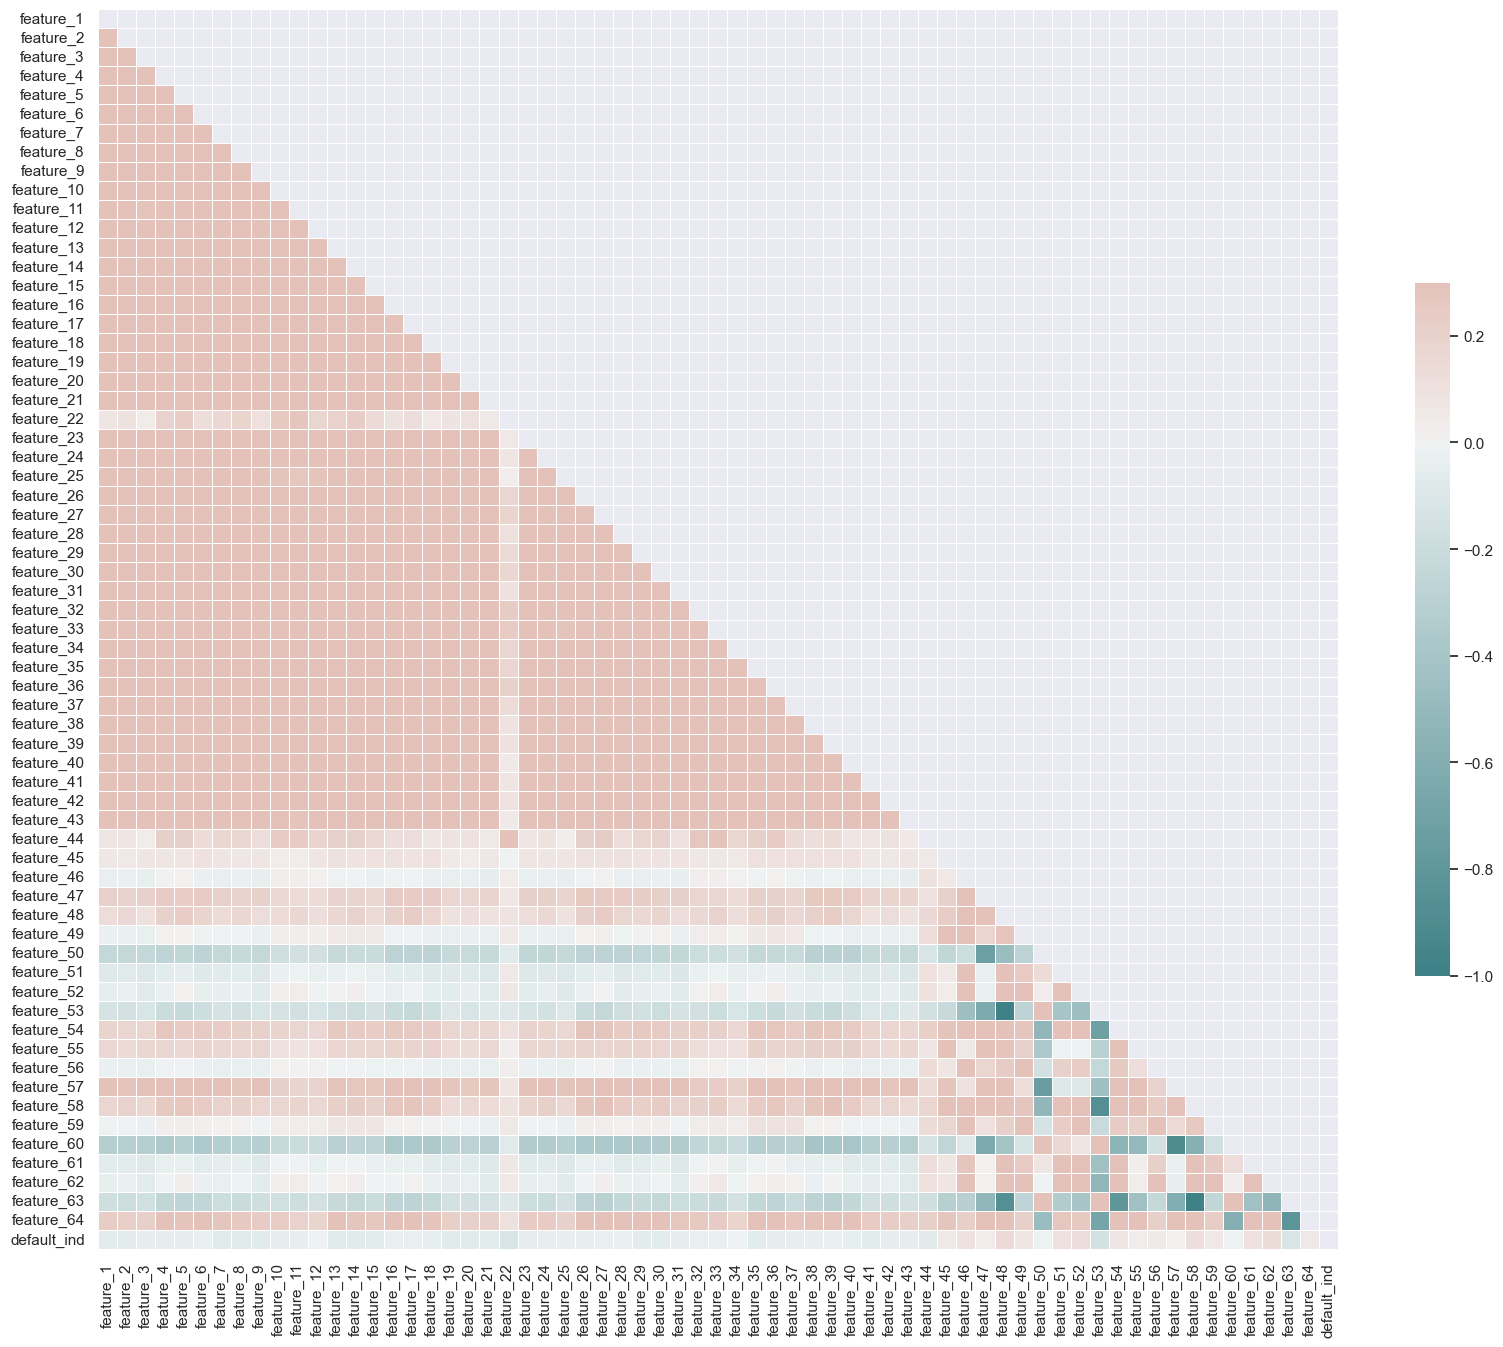

In [7]:
sns.set_theme(style="dark")
f, ax = plt.subplots(figsize=(20,18))
mask = np.triu(np.ones_like(correlation_matrix, dtype=bool))
cmap = sns.diverging_palette(200, 20, as_cmap=True)
sns.heatmap(correlation_matrix, mask=mask, cmap=cmap, vmax=.3, center=0, annot=False,
            square=True, linewidths=.5, cbar_kws={"shrink": .5})

- we almost see a split around `feature_44` around the correlation of data
- where `feature_1` through `feature_44` are relativey weakly correlated negatively with our target variable
- standouts for positive correlation is `feature_48`, `feature_49`, `feature_58`, `feature_59`, `feature_58` and `feature_59`

So we can keep the stronger correlations in the heatmap in mind when we will look at the variables of importance once we train some initial model/s to see which fits best

### Model training as a form of EDA
We will be using tensorflow for this, as it is super efficient and lightweight, as rerunning with different variables of importance is less of a hastle. Just to do some quick validation after our EDA

In [8]:
import numpy as np

def split_dataset(dataset, test_ratio=0.30):
  test_indices = np.random.rand(len(dataset)) < test_ratio
  return dataset[~test_indices], dataset[test_indices]

train_ds_pd, valid_ds_pd = split_dataset(df)
print("{} examples in training, {} examples in testing.".format(
    len(train_ds_pd), len(valid_ds_pd)))

65923 examples in training, 28162 examples in testing.


In [9]:
import tensorflow_decision_forests as tfdf
import tensorflow as tf

label = 'default_ind'
train_ds = tfdf.keras.pd_dataframe_to_tf_dataset(train_ds_pd, label=label, task = tfdf.keras.Task.CLASSIFICATION)
valid_ds = tfdf.keras.pd_dataframe_to_tf_dataset(valid_ds_pd, label=label, task = tfdf.keras.Task.CLASSIFICATION)

2025-06-05 23:23:52.711876: I metal_plugin/src/device/metal_device.cc:1154] Metal device set to: Apple M4 Pro
2025-06-05 23:23:52.711909: I metal_plugin/src/device/metal_device.cc:296] systemMemory: 24.00 GB
2025-06-05 23:23:52.711914: I metal_plugin/src/device/metal_device.cc:313] maxCacheSize: 8.00 GB
I0000 00:00:1749158632.711928  239078 pluggable_device_factory.cc:305] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
I0000 00:00:1749158632.711948  239078 pluggable_device_factory.cc:271] Created TensorFlow device (/job:localhost/replica:0/task:0/device:GPU:0 with 0 MB memory) -> physical PluggableDevice (device: 0, name: METAL, pci bus id: <undefined>)


In [10]:
rf = tfdf.keras.RandomForestModel(task = tfdf.keras.Task.CLASSIFICATION)
rf.compile(metrics=['mse'])

Use /var/folders/5x/n4xkh3_j713g4s6p4b3ltx3m0000gn/T/tmpcjw91qsj as temporary training directory


In [ ]:
rf.fit(train_ds)


In [ ]:
rf.summary()

In [13]:
inspector = rf.make_inspector()
inspector.evaluation()


Evaluation(num_examples=65923, accuracy=0.9264748266917464, loss=0.29318325580501003, rmse=None, ndcg=None, aucs=None, auuc=None, qini=None)

In [14]:
evaluation = rf.evaluate(valid_ds,return_dict=True)

for name, value in evaluation.items():
  print(f"{name}: {value:.4f}")


29/29 [==============================] - 1s 34ms/step - loss: 0.0000e+00 - mse: 0.0577
loss: 0.0000
mse: 0.0577


In [15]:
evaluation

{'loss': 0.0, 'mse': 0.057709407061338425}

In [16]:
print(f"Available variable importances:")
for importance in inspector.variable_importances().keys():
  print("\t", importance)

Available variable importances:
	 INV_MEAN_MIN_DEPTH
	 NUM_AS_ROOT
	 SUM_SCORE
	 NUM_NODES


In [17]:
inspector.variable_importances()["NUM_AS_ROOT"]


[("feature_48" (1; #43), 41.0),
 ("feature_58" (1; #54), 34.0),
 ("feature_53" (1; #49), 33.0),
 ("feature_62" (1; #59), 27.0),
 ("feature_51" (1; #47), 25.0),
 ("feature_52" (1; #48), 23.0),
 ("feature_47" (1; #42), 20.0),
 ("feature_63" (1; #60), 16.0),
 ("feature_55" (1; #51), 11.0),
 ("feature_61" (1; #58), 10.0),
 ("feature_45" (1; #40), 9.0),
 ("feature_46" (1; #41), 7.0),
 ("feature_50" (1; #46), 7.0),
 ("feature_54" (1; #50), 7.0),
 ("feature_57" (1; #53), 6.0),
 ("feature_64" (1; #61), 5.0),
 ("feature_22" (1; #15), 3.0),
 ("feature_8" (1; #63), 3.0),
 ("feature_13" (1; #5), 2.0),
 ("feature_19" (1; #11), 2.0),
 ("feature_44" (1; #39), 2.0),
 ("feature_7" (1; #62), 2.0),
 ("feature_9" (1; #64), 2.0),
 ("feature_14" (1; #6), 1.0),
 ("feature_20" (1; #13), 1.0),
 ("feature_21" (1; #14), 1.0)]

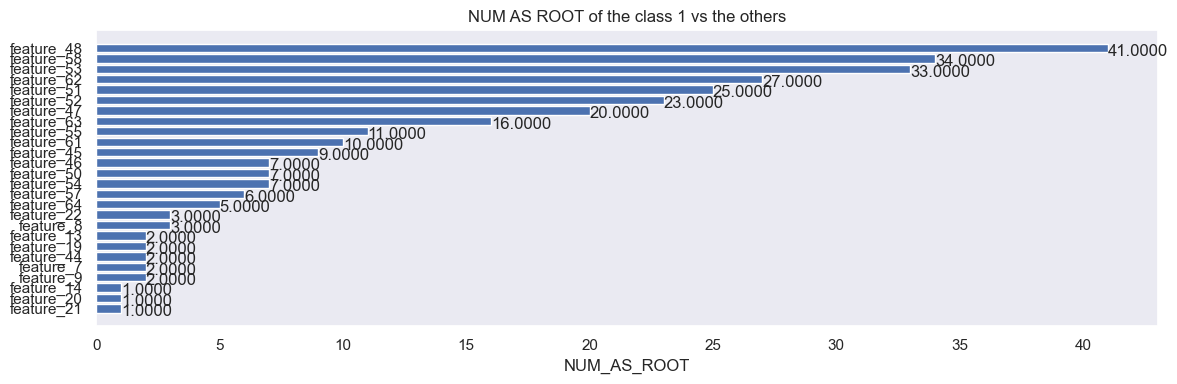

In [ ]:
plt.figure(figsize=(12, 4))
# Mean decrease in AUC of the class 1 vs the others.
variable_importance_metric = "NUM_AS_ROOT"
variable_importances = inspector.variable_importances()[variable_importance_metric]
feature_names = [vi[0].name for vi in variable_importances]
feature_importances = [vi[1] for vi in variable_importances]
# The feature are ordered in decreasing importance value.
feature_ranks = range(len(feature_names))
bar = plt.barh(feature_ranks, feature_importances, label=[str(x) for x in feature_ranks])
plt.yticks(feature_ranks, feature_names)
plt.gca().invert_yaxis()
for importance, patch in zip(feature_importances, bar.patches):
  plt.text(patch.get_x() + patch.get_width(), patch.get_y(), f"{importance:.4f}", va="top")
plt.xlabel(variable_importance_metric)
plt.title("NUM AS ROOT of the class 1 vs the others")
plt.tight_layout()
plt.show()

## Start of training binary classifier using xgboost
- Ended up changing some of the input variables to the Classifier.
- Note the `10.4500425946` for `scale_pos_weight`, and is the ratio of the class imbalance as mentioned in the bar chart that we had earlier.
- Changing this to this larger value had a much greatest impact on many of the evaluation metrics at the end in making the model more accurate considering the imbalance.
- This would indicate some hyper paramer tuning could be more useful, and could be done in a later rendition of this model.

In [ ]:
df = pd.read_csv('local_kunda.csv')
df = df.drop(['customerid', 'loanid', 'date_add', 'prodcode','write_off_ind'], axis=1)

X = df.drop(columns='default_ind')
y = df[['default_ind']]
from sklearn.model_selection import train_test_split
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.3, random_state=42)
from xgboost import XGBClassifier
# model = XGBClassifier(use_label_encoder=False, eval_metric='logloss',)
model = XGBClassifier(
    objective='binary:logistic',
    eval_metric='logloss',
    use_label_encoder=False,          
    scale_pos_weight=10.4500425946,   # Adjust based on class imbalance
    max_depth=5,                      
    learning_rate=0.01,               
    n_estimators=3000,              
    subsample=0.8,                    
    colsample_bytree=0.8,             
    gamma=1,                          
    min_child_weight=10,              
    reg_alpha=0.5,                   
    reg_lambda=1,                     
    random_state=42
)
model.fit(X_train, y_train)




/Users/pieterdevilliers/PersonalProjects/data-scoring/tf-env/lib/python3.11/site-packages/xgboost/training.py:183: UserWarning: [23:24:04] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=0.8, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric='logloss',
              feature_types=None, feature_weights=None, gamma=1,
              grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=0.01, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=5, max_leaves=None,
              min_child_weight=10, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=3000, n_jobs=None,
              num_parallel_tree=None, ...)

In [20]:
df.shape

(94085, 65)

In [21]:
y_pred_proba = model.predict_proba(X_val)[:, 1] 
# Convert to binary predictions (defaults) using 0.5 threshold (or tune this)
y_pred = (y_pred_proba > 0.5).astype(int)

probability portion can be optimized since there is great class imbalance. ie tuning

In [ ]:
from sklearn.metrics import (
    accuracy_score, precision_score, recall_score, f1_score, roc_auc_score, confusion_matrix, classification_report
)
print("Accuracy:", accuracy_score(y_val, y_pred))
print("Precision:", precision_score(y_val, y_pred))
print("Recall:", recall_score(y_val, y_pred))
print("F1 Score:", f1_score(y_val, y_pred))
print("ROC AUC:\n", roc_auc_score(y_val, y_pred_proba))
print("Confusion Matrix:\n", confusion_matrix(y_val, y_pred))
print("\nClassification Report:\n", classification_report(y_val, y_pred))

Accuracy: 0.8477644724721888
Precision: 0.32631379244925063
Recall: 0.6974858069748581
F1 Score: 0.4446167765283702
ROC AUC:
 0.862220830625702
Confusion Matrix:
 [[22209  3551]
 [  746  1720]]

Classification Report:
               precision    recall  f1-score   support

           0       0.97      0.86      0.91     25760
           1       0.33      0.70      0.44      2466

    accuracy                           0.85     28226
   macro avg       0.65      0.78      0.68     28226
weighted avg       0.91      0.85      0.87     28226



- Focused on trying to maximize the recall as best I could, to actually stop the most likely default_ind from taking loans
- Would have liked to have the accuracy a bit higher, but could maybe set target accuracy compared to the class imbalance in the future as a constraint, and potentially try multiple models to set a goal based model learning. 

## Some analysis of importance and influence variables while model was trained

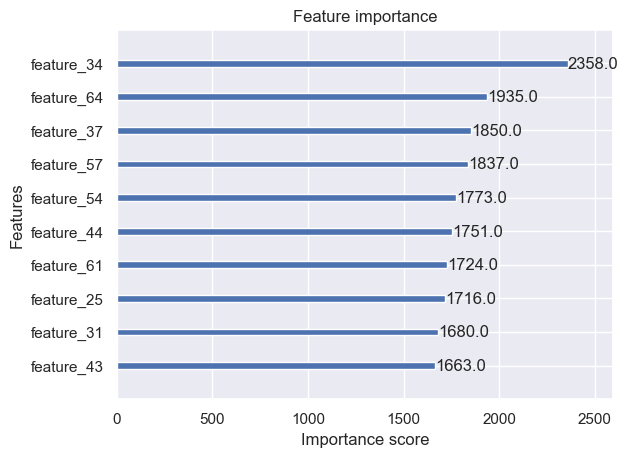

In [23]:
import matplotlib.pyplot as plt
from xgboost import plot_importance

plot_importance(model, max_num_features=10)
plt.show()

- In the above one the main outlier compared to the exploration that i did initially, was `feature_34` by far
- Some of the other variables did show up a bit when it came to the correlation heatmap that we did for the correlation matrix

## Beeswarm visualisation
### Quoted from the shap documentation:

"The beeswarm plot is designed to display an information-dense summary of how the top features in a dataset impact the model’s output. Each instance the given explanation is represented by a single dot on each feature row. The x position of the dot is determined by the SHAP value (`shap_values.value[instance,feature]`) of that feature, and dots “pile up” along each feature row to show density. Color is used to display the original value of a feature (`shap_values.data[instance,feature]`)."

In short, its good. It provides a way to visualise density and direction through volume and colour.

In [24]:
import shap
explainer = shap.Explainer(model, X_train)
shap_values = explainer(X_train)

100%|===================| 65849/65859 [43:33<00:00]        

yes this did take 40 mins to run :)

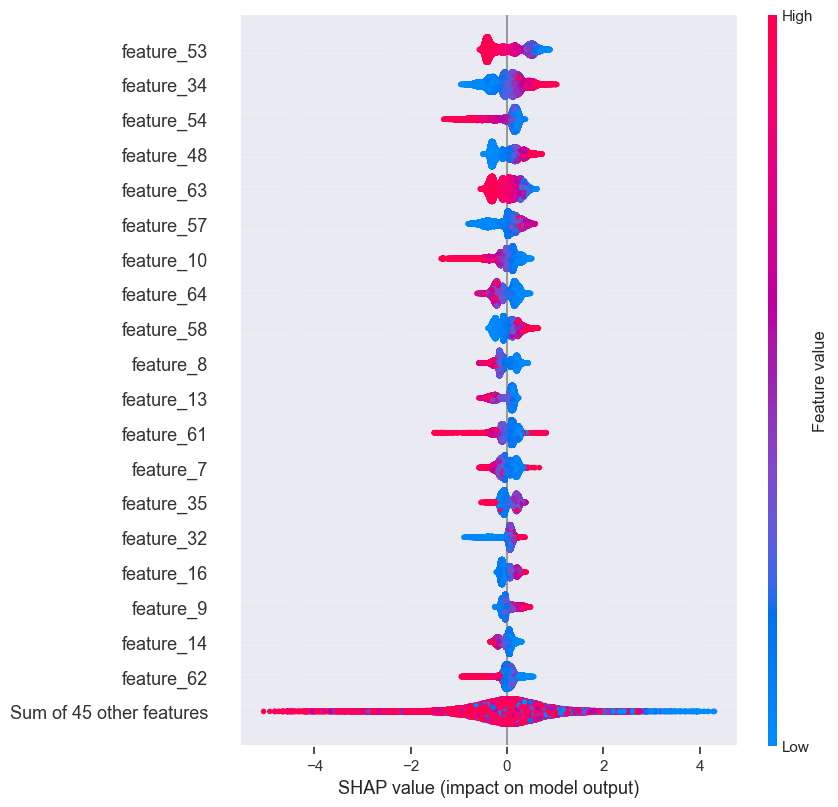

In [28]:
shap.plots.beeswarm(shap_values, max_display=20)


- This time `feature_53` overtook  `feature_34` and our eye on the correlation heatmap at meant more. 

## Conclusion

### Takeaways
- Was able to identify the class imbalance and really took its toll on evaluation metrics
- Data was clean and not much was needed in terms of dealing with NaNs etc.
- Xgboost is still much better out of the box thank tensorflow since i could include the class imbalance in the creation of the model.

### Improvements
- Would like to do a round robin fold test of multiple models.
- Hyper parameter tuning could be useful when working with the intense class imbalances.
- Setting up some more rule/weighted based scoring now that we know which categories had big inluence.




---------------- thank you for reading my first proper data-science notebook - pieter ------------------------
